# Transfer Learning with MobileNetV2
Chào mừng bạn đến với nhiệm vụ của tuần này, nơi bạn sẽ sử dụng phương pháp học chuyển tiếp trên CNN được đào tạo trước để xây dựng bộ phân loại Alpaca / Không phải Alpaca!

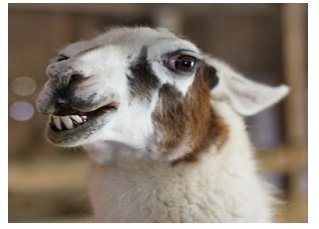


Mô hình được đào tạo trước là một mạng đã được đào tạo trên một tập dữ liệu lớn và được lưu, cho phép bạn sử dụng nó để tùy chỉnh mô hình của riêng mình với chi phí rẻ và hiệu quả. Ứng dụng bạn sẽ sử dụng, MobileNetV2, được thiết kế để cung cấp hiệu suất nhanh chóng và hiệu quả về mặt tính toán. Nó đã được đào tạo trước trên ImageNet, một tập dữ liệu chứa hơn 14 triệu hình ảnh và 1000 lớp.

Khi kết thúc nhiệm vụ này, bạn sẽ có thể:

- Tạo tập dữ liệu từ một thư mục
- Dữ liệu tiền xử lý và tăng cường bằng cách sử dụng API tuần tự
- Điều chỉnh mô hình được đào tạo trước với dữ liệu mới và đào tạo bộ phân loại bằng cách sử dụng API chức năng và MobileNet
- Tinh chỉnh các lớp cuối cùng của trình phân loại để cải thiện độ chính xác

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Exercise 1 - data_augmenter](#ex-1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Exercise 2 - alpaca_model](#ex-2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [Exercise 3](#ex-3)

<a name='1'></a>
## 1 - Packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Create the Dataset and Split it into Training and Validation Sets
Khi đào tạo và đánh giá các mô hình học sâu trong Keras, việc tạo tập dữ liệu từ các tệp hình ảnh được lưu trữ trên đĩa rất đơn giản và nhanh chóng. Gọi `image_data_set_from_directory ()` để đọc từ thư mục và tạo cả tập dữ liệu đào tạo và xác nhận.

Nếu bạn đang chỉ định phân tách xác thực, bạn cũng cần chỉ định tập hợp con cho từng phần. Chỉ cần đặt tập hợp đào tạo thành `subset='training'` và tập xác nhận thành `subset='validation' `.

Bạn cũng sẽ đặt các hạt giống của mình phù hợp với nhau, vì vậy các tập hợp đào tạo và xác nhận của bạn không trùng lặp. :)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "drive/MyDrive/datasets"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Bây giờ chúng ta cùng xem qua một số hình ảnh từ buổi tập:

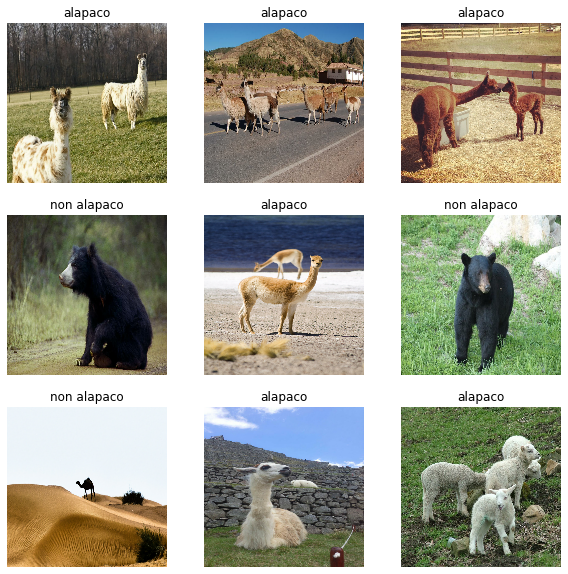

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data
Bạn có thể đã gặp phải `dataset.prefetch` trong một nhiệm vụ TensorFlow trước đó, như một bước bổ sung quan trọng trong quá trình tiền xử lý dữ liệu.

Sử dụng `prefetch ()` ngăn chặn tắc nghẽn bộ nhớ có thể xảy ra khi đọc từ đĩa. Nó dành một số dữ liệu và giữ cho nó sẵn sàng khi cần, bằng cách tạo tập dữ liệu nguồn từ dữ liệu đầu vào của bạn, áp dụng một phép chuyển đổi để xử lý trước, sau đó lặp lại từng phần tử trong tập dữ liệu. Vì quá trình lặp đang truyền trực tuyến nên dữ liệu không cần phải vừa với bộ nhớ.

Bạn có thể đặt số lượng phần tử để tìm nạp trước theo cách thủ công hoặc bạn có thể sử dụng `tf.data.experimental.AUTOTUNE` để chọn các tham số tự động. Autotune nhắc `tf.data` điều chỉnh động giá trị đó trong thời gian chạy, bằng cách theo dõi thời gian dành cho mỗi hoạt động và đưa những khoảng thời gian đó vào một thuật toán tối ưu hóa. Thuật toán tối ưu hóa cố gắng tìm cách phân bổ ngân sách CPU tốt nhất trên tất cả các hoạt động có thể điều chỉnh được.

Để tăng tính đa dạng trong tập huấn luyện và giúp mô hình của bạn học dữ liệu tốt hơn, phương pháp tiêu chuẩn là tăng cường hình ảnh bằng cách biến đổi chúng, tức là lật và xoay chúng một cách ngẫu nhiên. API tuần tự của Keras cung cấp một phương pháp đơn giản cho các loại tăng cường dữ liệu này, với các lớp tiền xử lý có thể tùy chỉnh, tích hợp sẵn. Các lớp này được lưu với phần còn lại của mô hình của bạn và có thể được sử dụng lại sau này. Ahh, thật tiện lợi!

Như mọi khi, bạn được mời đọc các tài liệu chính thức, mà bạn có thể tìm thấy để tăng dữ liệu [tại đây](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercise 1 - data_augmenter
Thực hiện một chức năng để tăng dữ liệu. Sử dụng mô hình keras `Sequential` bao gồm 2 lớp:
* `RandomFlip ('horizontal')`
* `RandomRotation (0.2)`

In [ ]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [ ]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')

All tests passed!


Hãy xem một hình ảnh từ tập huấn luyện đã được tăng cường như thế nào với các phép biến đổi đơn giản:

Từ một con vật dễ thương, đến 9 biến thể của con vật dễ thương đó, trong ba dòng mã. Giờ đây, mô hình của bạn có rất nhiều thứ để học hỏi.

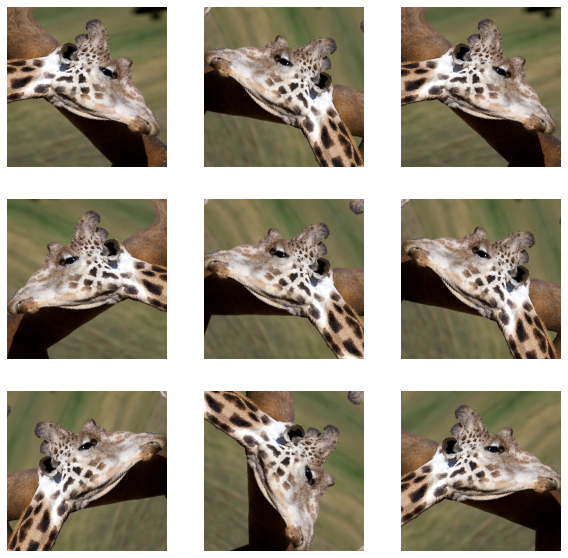

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Tiếp theo, bạn sẽ áp dụng công cụ đầu tiên của mình từ ứng dụng MobileNet trong TensorFlow, để chuẩn hóa đầu vào của bạn. Vì bạn đang sử dụng mô hình được đào tạo trước đã được đào tạo về các giá trị chuẩn hóa [-1,1], nên cách tốt nhất là sử dụng lại tiêu chuẩn đó với tf.keras.application.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**Điều bạn nên nhớ:**

* Khi gọi image_data_set_from_directory (), hãy chỉ định tập con train / val và so khớp các hạt để ngăn chồng chéo
* Sử dụng tìm nạp trước () để tránh tắc nghẽn bộ nhớ khi đọc từ đĩa
* Cung cấp cho mô hình của bạn nhiều điều để học hỏi hơn với các phép tăng cường dữ liệu đơn giản như xoay và lật.
* Khi sử dụng mô hình đã được huấn luyện trước, tốt nhất bạn nên sử dụng lại trọng lượng mà nó đã được huấn luyện.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 
MobileNetV2 đã được đào tạo về ImageNet và được tối ưu hóa để chạy trên thiết bị di động và các ứng dụng tiêu thụ điện năng thấp khác. Nó sâu 155 lớp (chỉ trong trường hợp bạn cảm thấy thôi thúc tự vẽ mô hình, chuẩn bị cho một hành trình dài!) Và rất hiệu quả cho các nhiệm vụ phát hiện đối tượng và phân đoạn hình ảnh, cũng như các nhiệm vụ phân loại như thế này. Kiến trúc có ba đặc điểm xác định:

* Các chập có thể phân tách theo chiều sâu
* Ngắt cổ chai đầu vào và đầu ra mỏng giữa các lớp
* Kết nối lối tắt giữa các lớp nút cổ chai

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block
MobileNetV2 sử dụng các tập hợp có thể phân tách theo chiều sâu làm các khối xây dựng hiệu quả. Các phép chập truyền thống thường rất tốn tài nguyên và các phép chập có thể phân tách theo chiều sâu có thể làm giảm số lượng các tham số và phép toán có thể huấn luyện và cũng tăng tốc độ cho các phép chập theo hai bước:

1. Bước đầu tiên tính toán kết quả trung gian bằng cách xoay vòng trên từng kênh một cách độc lập. Đây là tích chập theo chiều sâu.

2. Trong bước thứ hai, một phép chập khác hợp nhất các đầu ra của bước trước đó thành một. Điều này nhận được một kết quả duy nhất từ một tính năng duy nhất tại một thời điểm và sau đó được áp dụng cho tất cả các bộ lọc trong lớp đầu ra. Đây là tích chập theo chiều kim hoặc: **Shape of the depthwise convolution X Number of filters.**

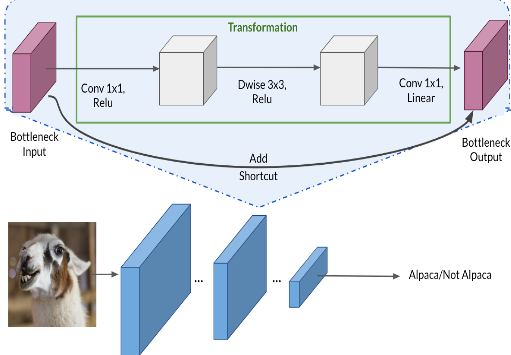

<b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Mỗi khối bao gồm một cấu trúc dư ngược với một nút cổ chai ở mỗi đầu. Các nút thắt cổ chai này mã hóa các đầu vào và đầu ra trung gian trong một không gian chiều thấp và ngăn chặn sự không tuyến tính phá hủy thông tin quan trọng.

Các kết nối lối tắt, tương tự như các kết nối trong mạng dư truyền thống, phục vụ cùng một mục đích là tăng tốc đào tạo và cải thiện dự đoán. Các kết nối này bỏ qua các vòng chập trung gian và kết nối các lớp nút cổ chai.

Hãy thử đào tạo mô hình cơ sở của bạn bằng cách sử dụng tất cả các lớp từ mô hình được đào tạo trước.

Tương tự như cách bạn sử dụng lại các giá trị chuẩn hóa trước mà MobileNetV2 đã được đào tạo, bạn cũng sẽ tải các trọng số được đào tạo trước từ ImageNet bằng cách chỉ định `weights = 'imagenet' '.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In tóm tắt mô hình bên dưới để xem tất cả các lớp của mô hình, hình dạng của đầu ra của chúng và tổng số thông số, có thể đào tạo và không thể đào tạo.

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Lưu ý 2 lớp cuối cùng ở đây. Chúng được gọi là các lớp trên cùng và chúng chịu trách nhiệm phân loại trong mô hình

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


Lưu ý một số lớp trong bản tóm tắt, như DepthwiseConv2D và SephableConv2D. Đây là một phần của lớp mở rộng trung gian đã đề cập trước đó.

<font color = 'blue'>

**Những gì bạn nên nhớ**:

* Các tính năng độc đáo của MobileNetV2 là:
   * Các tập hợp có thể phân tách theo chiều sâu cung cấp tính năng lọc và tạo tính năng nhẹ
   * Các nút thắt cổ chai đầu vào và đầu ra lưu giữ thông tin quan trọng ở một trong hai đầu của khối
* Các tập hợp có thể phân tách theo chiều sâu xử lý cả kích thước không gian và chiều sâu (số kênh)

Tiếp theo, chọn lô đầu tiên từ tập dữ liệu tensorflow để sử dụng hình ảnh và chạy nó thông qua mô hình cơ sở MobileNetV2 để kiểm tra các dự đoán trên một số hình ảnh của bạn.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Ồ. Có rất nhiều nhãn ở đây, một số trong số chúng sai một cách vui nhộn, nhưng không có nhãn nào trong số chúng nói "alpaca".

Điều này là do MobileNet được đào tạo trước qua ImageNet không có nhãn chính xác cho alpacas, vì vậy khi bạn sử dụng mô hình đầy đủ, tất cả những gì bạn nhận được là một loạt các hình ảnh được phân loại không chính xác.

May mắn thay, bạn có thể xóa lớp trên cùng, nơi chứa tất cả các nhãn phân loại và tạo một lớp phân loại mới.

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.425822),
  ('n02708093', 'analog_clock', 0.09275597)],
 [('n04589890', 'window_screen', 0.23985972),
  ('n03887697', 'paper_towel', 0.14802639)],
 [('n04589890', 'window_screen', 0.7449457),
  ('n03598930', 'jigsaw_puzzle', 0.021948513)],
 [('n04589890', 'window_screen', 0.33546048),
  ('n03530642', 'honeycomb', 0.07628931)],
 [('n04589890', 'window_screen', 0.2732732),
  ('n03733281', 'maze', 0.08846962)],
 [('n04589890', 'window_screen', 0.6745255),
  ('n03530642', 'honeycomb', 0.07659863)],
 [('n04589890', 'window_screen', 0.79128563),
  ('n04209239', 'shower_curtain', 0.092415996)],
 [('n04589890', 'window_screen', 0.16462994),
  ('n03598930', 'jigsaw_puzzle', 0.08749185)],
 [('n03598930', 'jigsaw_puzzle', 0.3702138),
  ('n04589890', 'window_screen', 0.09956951)],
 [('n04589890', 'window_screen', 0.6161674),
  ('n03887697', 'paper_towel', 0.054876648)],
 [('n03530642', 'honeycomb', 0.25448853),
  ('n04589890', 'window_screen', 0.24874403)],
 [('n0

### 3.2 - Layer Freezing with the Functional API

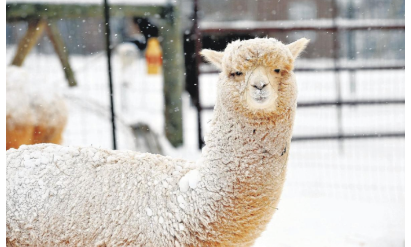

Trong các phần tiếp theo, bạn sẽ thấy cách bạn có thể sử dụng một mô hình được đào tạo trước để sửa đổi nhiệm vụ của trình phân loại để nó có thể nhận ra các alpacas. Bạn có thể đạt được điều này trong ba bước:

1. Xóa lớp trên cùng (lớp phân loại)
     * Đặt `include_top` trong` base_model` là False
2. Thêm một lớp phân loại mới
     * Chỉ đào tạo một lớp bằng cách đóng băng phần còn lại của mạng
     * Như đã đề cập trước đây, một nơron đơn lẻ là đủ để giải quyết vấn đề phân loại nhị phân.
3. Đóng băng mô hình cơ sở và đào tạo lớp phân loại mới được tạo
     * Đặt `base model.trainable = False` để tránh thay đổi trọng lượng và đào tạo *only* lớp mới
     * Đặt đào tạo trong `base_model` thành False để tránh theo dõi số liệu thống kê trong lớp định mức hàng loạt

<a name='ex-2'></a>
### Exercise 2 - alpaca_model

In [ ]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
 
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(units=1)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

Tạo mô hình mới của bạn bằng cách sử dụng chức năng tăng dữ liệu được xác định trước đó.

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
from test_utils import summary, comparator
print(summary)
alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

#comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    

<function summary at 0x7fd6aadfb950>
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


Tốc độ học cơ bản đã được đặt cho bạn, vì vậy bạn có thể tiếp tục và biên dịch mô hình mới và chạy nó trong 5 kỷ nguyên:

In [ ]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
9/9 [==============================] - 10s 845ms/step - loss: 0.2527 - accuracy: 0.8740 - val_loss: 0.1076 - val_accuracy: 0.9385
Epoch 2/10
9/9 [==============================] - 10s 841ms/step - loss: 0.1805 - accuracy: 0.9313 - val_loss: 0.0959 - val_accuracy: 0.9538
Epoch 3/10
9/9 [==============================] - 10s 826ms/step - loss: 0.2155 - accuracy: 0.9084 - val_loss: 0.1963 - val_accuracy: 0.8923
Epoch 4/10
9/9 [==============================] - 10s 810ms/step - loss: 0.2750 - accuracy: 0.8740 - val_loss: 0.1314 - val_accuracy: 0.9385
Epoch 5/10
9/9 [==============================] - 10s 821ms/step - loss: 0.2244 - accuracy: 0.8969 - val_loss: 0.1505 - val_accuracy: 0.9385
Epoch 6/10
9/9 [==============================] - 10s 837ms/step - loss: 0.1776 - accuracy: 0.9351 - val_loss: 0.0871 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 10s 831ms/step - loss: 0.1578 - accuracy: 0.9275 - val_loss: 0.0705 - val_accuracy: 0.9692
Epoch 8/10
9/

Lập biểu đồ đào tạo và xác nhận độ chính xác:

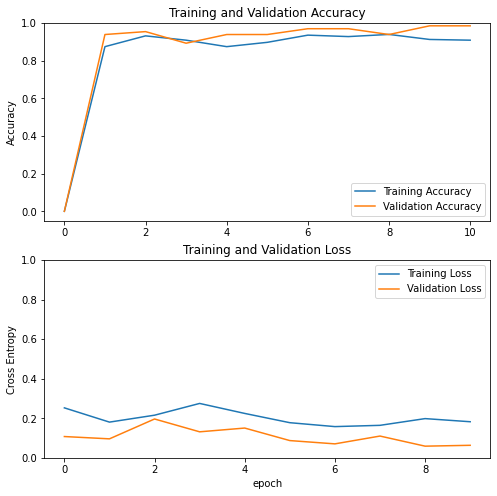

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

['alapaco', 'non alapaco']

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model
Bạn có thể thử tinh chỉnh mô hình bằng cách chạy lại trình tối ưu hóa ở các lớp cuối cùng để cải thiện độ chính xác. Khi bạn sử dụng tốc độ học tập nhỏ hơn, bạn sẽ thực hiện các bước nhỏ hơn để điều chỉnh nó chặt chẽ hơn một chút với dữ liệu mới. Trong học tập chuyển giao, cách bạn đạt được điều này là mở các lớp ở cuối mạng, sau đó đào tạo lại mô hình của bạn trên các lớp cuối cùng với tỷ lệ học tập rất thấp. Điều chỉnh tốc độ học tập của bạn để đi qua các lớp này theo các bước nhỏ hơn có thể mang lại nhiều chi tiết tốt hơn - và độ chính xác cao hơn.

Trực giác cho những gì đang xảy ra: khi mạng ở giai đoạn đầu, nó đào tạo trên các tính năng cấp thấp, như các cạnh. Trong các lớp sau, các đặc điểm phức tạp hơn, cấp độ cao hơn như lông xù hoặc tai nhọn bắt đầu xuất hiện. Đối với học chuyển tiếp, các tính năng cấp thấp có thể được giữ nguyên, vì chúng có các tính năng chung cho hầu hết các hình ảnh. Khi bạn thêm dữ liệu mới, bạn thường muốn các tính năng cấp cao thích ứng với nó, điều này giống như để mạng học cách phát hiện các tính năng liên quan nhiều hơn đến dữ liệu của bạn, chẳng hạn như lông mềm hoặc răng to.

Để đạt được điều này, chỉ cần giải phóng các lớp cuối cùng và chạy lại trình tối ưu hóa với tốc độ học tập nhỏ hơn, trong khi giữ tất cả các lớp khác ở trạng thái đóng băng.

Nơi các lớp cuối cùng thực sự bắt đầu hơi tùy ý, vì vậy hãy thoải mái thử với con số này một chút. Điểm mấu chốt quan trọng là các lớp sau là phần mạng của bạn chứa các chi tiết nhỏ (tai nhọn, đuôi có lông) cụ thể hơn cho vấn đề của bạn.

Đầu tiên, giải phóng mô hình cơ sở bằng cách đặt `base_model.trainable = True`, đặt một lớp để tinh chỉnh từ đó, sau đó đóng băng lại tất cả các lớp trước nó. Chạy lại nó trong một vài kỷ nguyên nữa và xem độ chính xác của bạn có được cải thiện hay không!

In [ ]:
# UNQ_C3

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

#Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
#Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
#Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=(0.01*base_learning_rate))
#Use accuracy as evaluation metric
metrics= ['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics = metrics)

Number of layers in the base model:  156


In [ ]:
# #assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
# assert loss_function.from_logits, "Use from_logits=True"
# assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
# assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
# assert metrics[0] == 'accuracy', "Wrong metric"

# print('\033[92mAll tests passed!')


All tests passed!


In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/60
9/9 [==============================] - 10s 821ms/step - loss: 0.0958 - accuracy: 0.9656 - val_loss: 0.0563 - val_accuracy: 0.9846
Epoch 11/60
9/9 [==============================] - 10s 828ms/step - loss: 0.1164 - accuracy: 0.9504 - val_loss: 0.0603 - val_accuracy: 0.9692
Epoch 12/60
9/9 [==============================] - 13s 1s/step - loss: 0.1382 - accuracy: 0.9427 - val_loss: 0.0658 - val_accuracy: 0.9538
Epoch 13/60
9/9 [==============================] - 11s 845ms/step - loss: 0.0978 - accuracy: 0.9656 - val_loss: 0.0518 - val_accuracy: 0.9846
Epoch 14/60
9/9 [==============================] - 10s 852ms/step - loss: 0.0934 - accuracy: 0.9695 - val_loss: 0.0511 - val_accuracy: 0.9846
Epoch 15/60
9/9 [==============================] - 10s 851ms/step - loss: 0.1445 - accuracy: 0.9351 - val_loss: 0.0500 - val_accuracy: 0.9846
Epoch 16/60
9/9 [==============================] - 10s 847ms/step - loss: 0.1290 - accuracy: 0.9504 - val_loss: 0.0522 - val_accuracy: 0.9846
Epoch 17/

Ahhh, khá là cải thiện! Một chút tinh chỉnh thực sự có thể đi một chặng đường dài.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

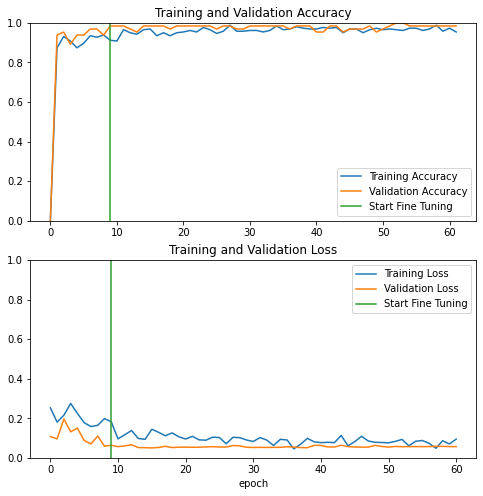

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color = 'blue'>

**Những gì bạn nên nhớ**:

* Để điều chỉnh trình phân loại với dữ liệu mới: Xóa lớp trên cùng, thêm một lớp phân loại mới và chỉ đào tạo trên lớp đó
* Khi đóng băng các lớp, tránh theo dõi số liệu thống kê (như trong lớp chuẩn hóa hàng loạt)
* Tinh chỉnh các lớp cuối cùng của mô hình của bạn để nắm bắt các chi tiết cấp cao gần cuối mạng và có khả năng cải thiện độ chính xác

## Xin chúc mừng!

Bạn đã hoàn thành bài tập này về việc học chuyển tiếp và tinh chỉnh. Đây là bản tóm tắt nhanh về tất cả những gì bạn vừa hoàn thành:

* Đã tạo tập dữ liệu từ một thư mục
* Tăng cường dữ liệu với API tuần tự
* Điều chỉnh mô hình được đào tạo trước thành dữ liệu mới với API chức năng và MobileNetV2
* Tinh chỉnh các lớp cuối cùng của bộ phân loại và tăng độ chính xác của mô hình

Thật tuyệt vời!